In [16]:
# Some imports to use in notebok
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
import scipy.spatial.distance as dist
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
import copy
import time
from tqdm import tqdm
from skimage import color
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

In [15]:
# Let's try a three facies approach:

df = pd.read_csv('C:\\Users\\Gerrit\\Desktop\\Masterarbeit\\masterarbeit_gerrit-main\\data_processed\\Querschnitt565756E_perfekt.csv',)
data = df.values
data = data[0::4]
data[:,0] = data[:,0]-data[:,0].min() # I think we should normalize the y-coordinates to be distances (in m)
y_max = data[:,0].max()
z_max = np.abs(data[:,1].min())# hier Minimum nehmen weil Tiefen negativ sind und dann Absolutwert

data_3 = copy.deepcopy(data)


data_k1 = copy.deepcopy(data_3)
data_k2 = copy.deepcopy(data_3)
data_k3 = copy.deepcopy(data_3)
data_k4 = copy.deepcopy(data_3)
data_k5 = copy.deepcopy(data_3)
data_k6 = copy.deepcopy(data_3)
data_k7 = copy.deepcopy(data_3)
data_k8 = copy.deepcopy(data_3)
data_k9 = copy.deepcopy(data_3)
data_k10 = copy.deepcopy(data_3)

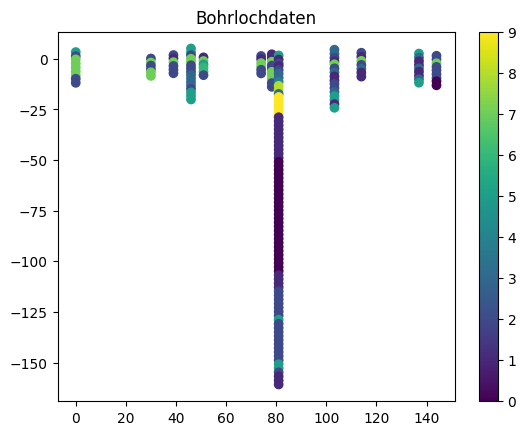

In [17]:
plt.scatter(x=data_3[:,0], y=data_3[:,1], c=data_3[:,2], cmap='viridis')
#plt.imshow(im_sub, cmap='gray', origin='lower')
plt.title('Bohrlochdaten')
plt.colorbar()

## 2. Variogram analyis
<a id="2"></a>

The first step of our geostatistical analysis is to describe the spatial correlation of our variable of interest. We do this in form of a variogram. 

In order to retrieve the variogram from our data we have to perform multiple steps. For each pointpair in our dataset we can calculate a measure of dissimilarity called *semivariance* ($\hat{\gamma}(\vec{h})$) that is dependent only on the distance between the two locations:

$$\hat{\gamma}(\vec{h}) = \frac{1}{2} \sum_{\alpha=1}^n \left(z(\vec{x_\alpha}+\vec{h}) - z(\vec{x_\alpha})\right)^2 $$

Plotting all semivariances against the so called *lag distance* ($\vec{h}$) leads to a plot called the *variogram cloud*, that is often quite messy due to the number of point pairs. To resolve this issue lag distances are binned based on a lag tolerance ($\Delta \vec{h}$) and the corresponding *semivariances* are averaged for each bin to create a plot called the *experimental varigoram*.
the customised function looks as follows:
$$\hat{\gamma}(\vec{h}) = \frac{1}{2} \sum_{\alpha=1}^n \left(z(\vec{x_\alpha}+\vec{h}) - z(\vec{x_\alpha})\right)^2*log(1+X)$$ 
In this function, X is a matrix that contains the distance in x-direction between all points.
between them looks like this:
The following function performs all the steps to create an *experimental variogram* based on a given dataset. 

In [19]:
def full_variogram(x_pos, y_pos, vals, bin_size, start=0, stop=180):
    """Calculate experimental variogram for sampled values
    
    **Arguments**:
        - x_pos (np.array) : x-coordiantes of sampled locations
        - y_pos (np.array) : y-coordiantes of sampled locations
        - vals (np.array) : values at corresponding x-y positions
        - bin_size (float) :bin size
        - start (float) : minimum lag distance
        - stop (float) : maximum lag distance
        
    **Returns**:
        - h_bins (np.array) = average lag distances for bins
        - ave_vals (np.array) = average semivariances for bins
    """
    X = np.vstack([x_pos, y_pos]).transpose()
    
    h = dist.squareform(dist.pdist(X))
    n = len(x_pos)

    gamma = np.empty((n, n))
    
    for pos in range (n):
        gamma[pos, :] = ((vals[:]-vals[pos])**2)/2 * np.log(1 + np.abs(X[:, 0] - X[pos, 0]))
    
    # Second step: Bins and stuff
    maxim = stop-start
    bins = maxim/bin_size
    bins = int(bins)

    h_bins = np.empty(bins)
    ave_vals = np.empty(bins)

    for j in range(bins):
        # create mask
        mask = np.where((h > start) & (h < (start+bin_size)))
        # use mask
        ave_vals[j] = np.average(gamma[mask])
        h_bins[j] = (start+start+bin_size)/2
        start += bin_size
        
    ## mask if there start to be nans in the ave_vals (ich nehme an das passiert wenn die Distanz größer wird als die Distanz der Daten)
    mask = ~np.isnan(ave_vals)

    return h_bins[mask], ave_vals[mask]

In [20]:
#defining experimental_varogramm to automatical fit the data
def exponential_variogram_model(d, range_, sill):
    '''Exponential variogram function
    
    **Arguments**:
        - d (np.array) : positions to evaluate function
        - range_ (float) : range parameter of model
        - sill (np.array) : sill parameter of model
        
    **Returns**:
        - gamma (np.array) : theoretical exponential semivariance
    '''
    nugget = 0 # Advanced 
    psill = sill- nugget
    gamma = psill * (1. - np.exp(-d / (range_))) + nugget
    return gamma

In [21]:
# first threshold for facies 1 
mask1 = data_k1[:,2]>0
data_k1[:,2][mask1]=0
data_k1[:,2][~mask1]=1

# second threshold for facies 2
mask2 = data_k2[:,2]==1
data_k2[:,2][mask2]=1
data_k2[:,2][~mask2]=0

# third threshold for facies 3 
mask3 = data_k3[:,2]==2
data_k3[:,2][mask3]=1
data_k3[:,2][~mask3]=0
# first threshold for facies 4 
mask4 = data_k4[:,2]==3
data_k4[:,2][mask4]=1
data_k4[:,2][~mask4]=0

# second threshold for facies 5
mask5 = data_k5[:,2]==4
data_k5[:,2][mask5]=1
data_k5[:,2][~mask5]=0

# third threshold for facies 6 
mask6 = data_k6[:,2]==5
data_k6[:,2][mask6]=1
data_k6[:,2][~mask6]=0
# first threshold for facies 7 
mask7 = data_k7[:,2]==6
data_k7[:,2][mask7]=1
data_k7[:,2][~mask7]=0

# second threshold for facies 8
mask8 = data_k8[:,2]==7
data_k8[:,2][mask8]=1
data_k8[:,2][~mask8]=0

# third threshold for facies 9 
mask9 = data_k9[:,2]==8
data_k9[:,2][mask9]=1
data_k9[:,2][~mask9]=0

# third threshold for facies 10
mask10 = data_k10[:,2]==9
data_k10[:,2][mask10]=1
data_k10[:,2][~mask10]=0

[28.19564571  0.34613461]
[126.58350398   0.99008707]
[45.30349628  0.85673592]
[9.52671352 0.2231818 ]
[0.94866195 0.00719389]
[56.031042    0.38507603]
[4.94800756 0.03391665]
[78.34395022  0.65116572]
[3.13877546 0.0147031 ]
[5.81180519 0.03774905]


Text(0, 0.5, 'Semivariance $\\gamma^*$')

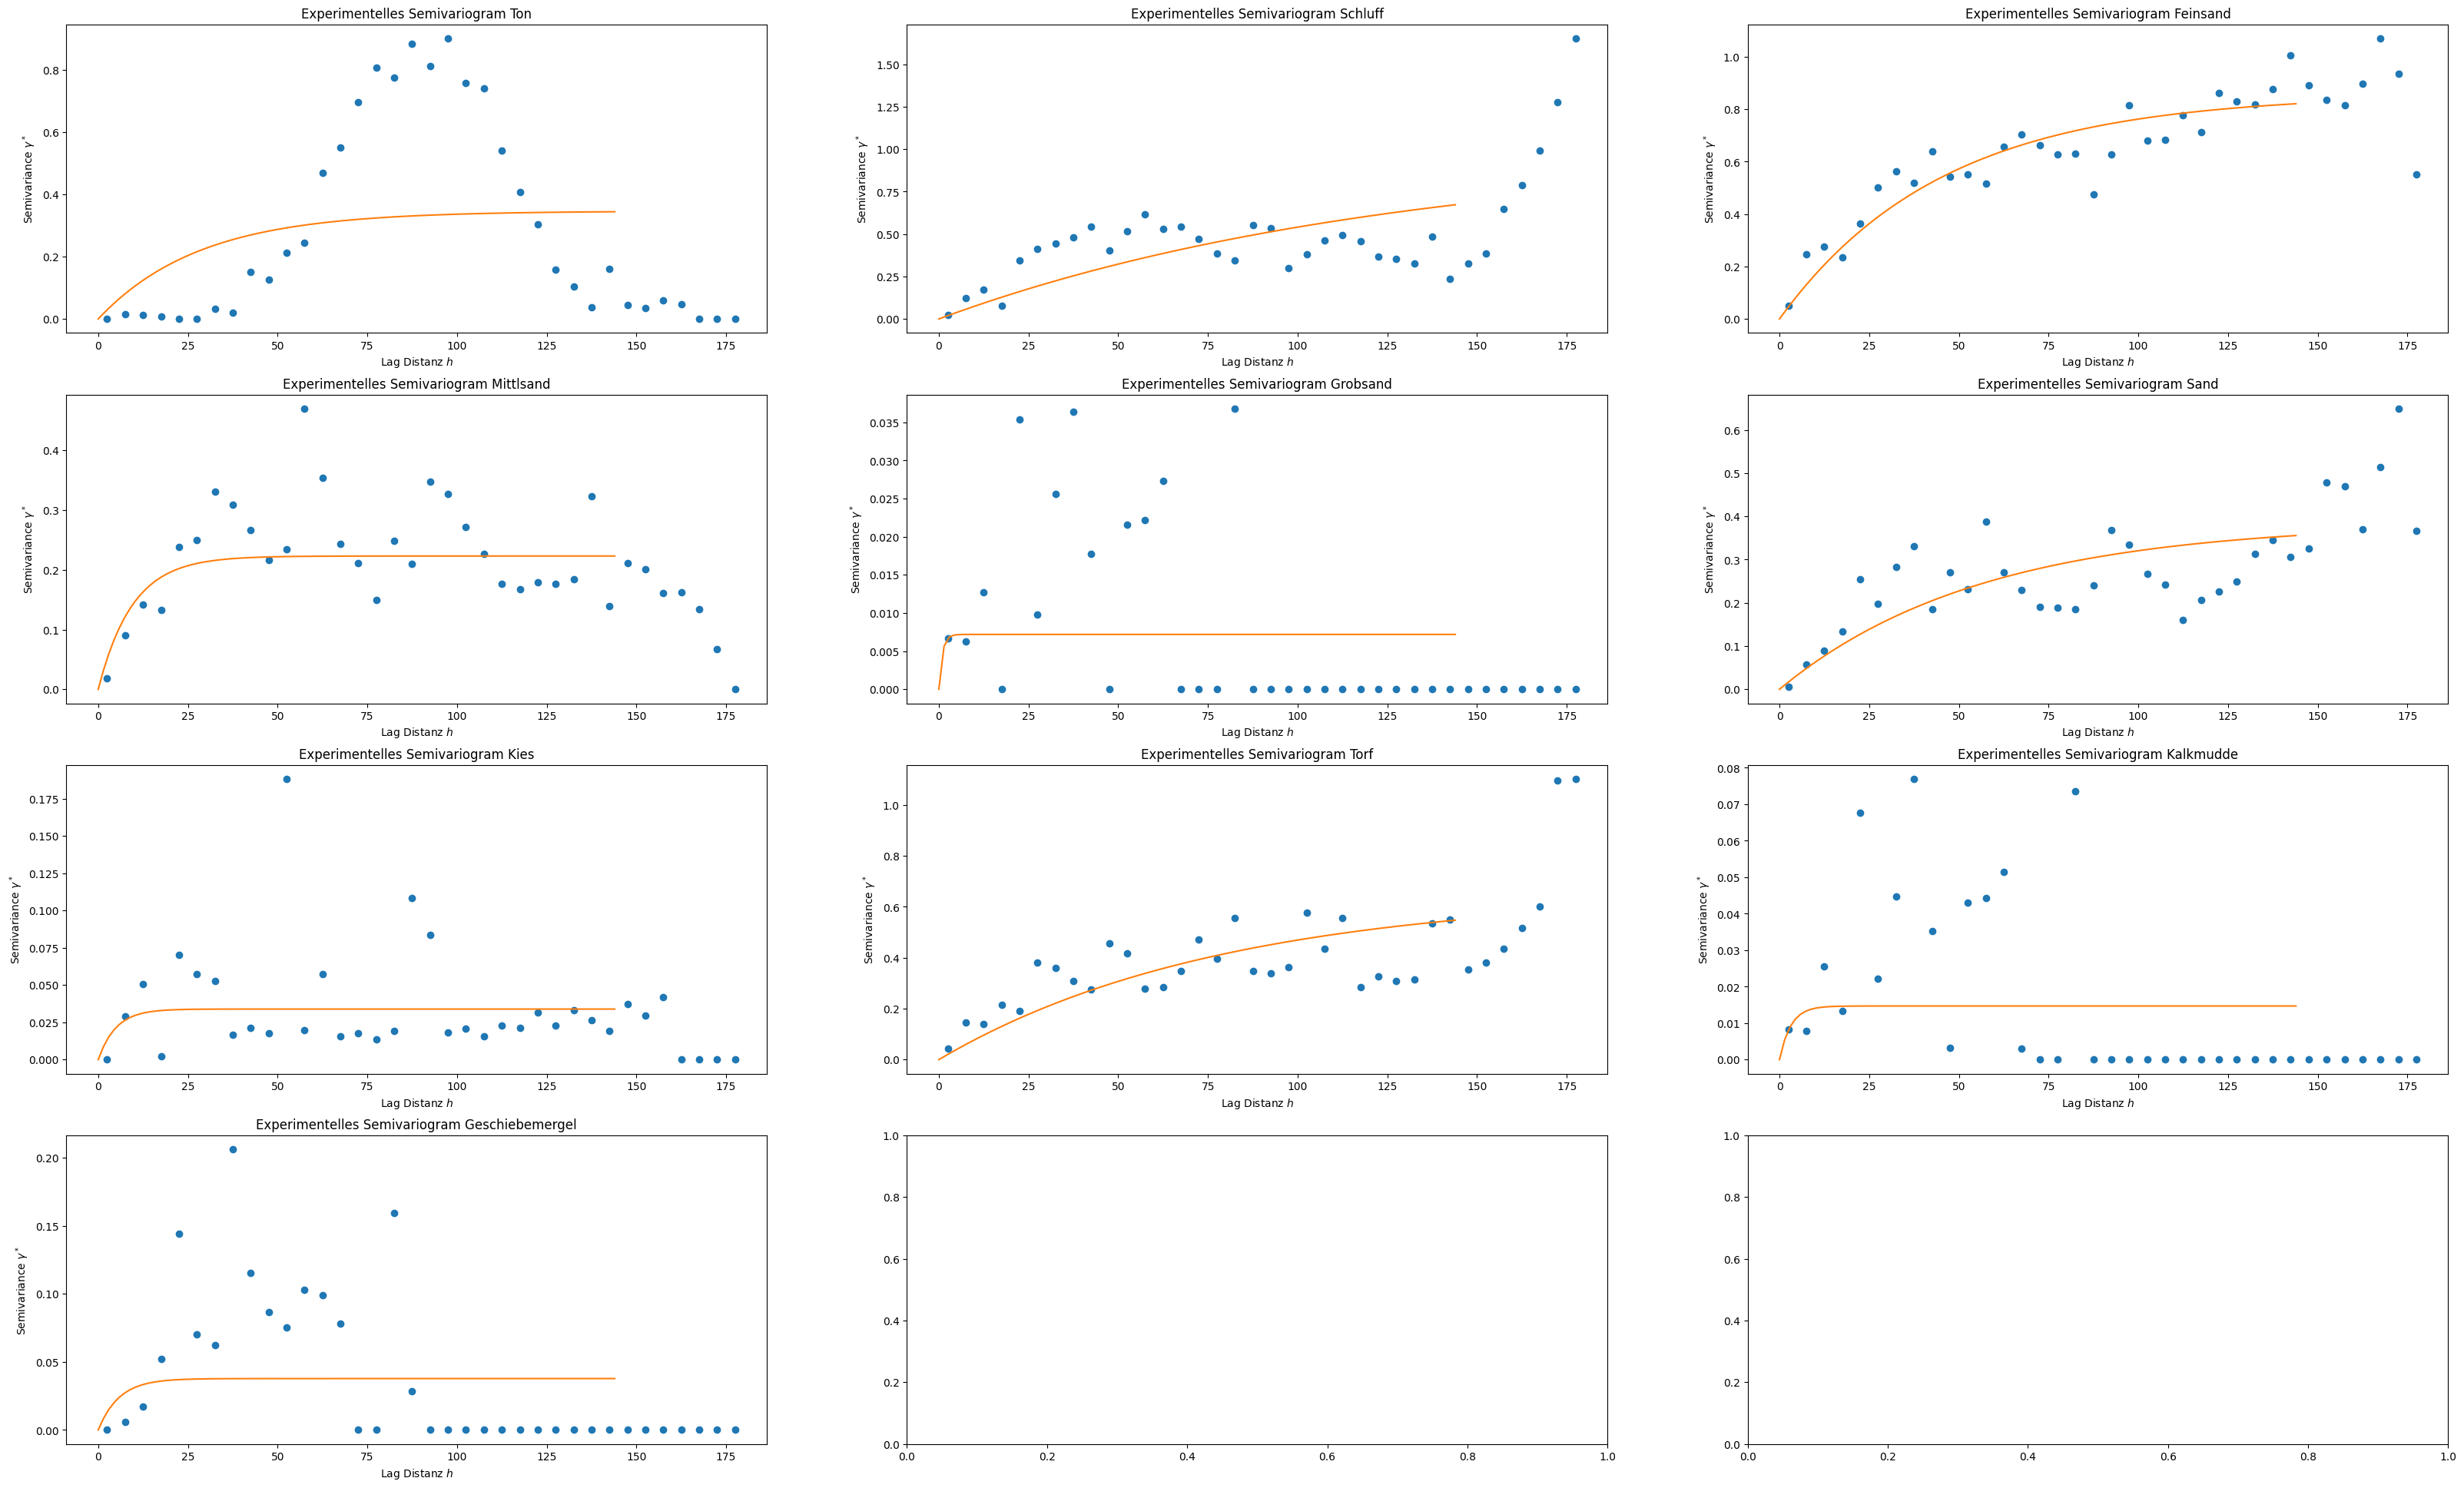

In [22]:
# Here we would actually require a step with a variogram for each threshold!

h_bins_k1, ave_vals_k1 = full_variogram(data_3[:,0], data_3[:,1], data_k1[:,2], 5)
h_bins_k2, ave_vals_k2 = full_variogram(data_3[:,0], data_3[:,1], data_k2[:,2], 5)
h_bins_k3, ave_vals_k3 = full_variogram(data_3[:,0], data_3[:,1], data_k3[:,2], 5)
h_bins_k4, ave_vals_k4 = full_variogram(data_3[:,0], data_3[:,1], data_k4[:,2], 5)
h_bins_k5, ave_vals_k5 = full_variogram(data_3[:,0], data_3[:,1], data_k5[:,2], 5)
h_bins_k6, ave_vals_k6 = full_variogram(data_3[:,0], data_3[:,1], data_k6[:,2], 5)
h_bins_k7, ave_vals_k7 = full_variogram(data_3[:,0], data_3[:,1], data_k7[:,2], 5)
h_bins_k8, ave_vals_k8 = full_variogram(data_3[:,0], data_3[:,1], data_k8[:,2], 5)
h_bins_k9, ave_vals_k9 = full_variogram(data_3[:,0], data_3[:,1], data_k9[:,2], 5)
h_bins_k10, ave_vals_k10 = full_variogram(data_3[:,0], data_3[:,1], data_k10[:,2], 5)

# automatied fitting
variogram_parameters1, par_b1 = curve_fit(exponential_variogram_model, h_bins_k1, ave_vals_k1)
variogram_parameters2, par_b2 = curve_fit(exponential_variogram_model, h_bins_k2, ave_vals_k2)
variogram_parameters3, par_b3 = curve_fit(exponential_variogram_model, h_bins_k3, ave_vals_k3)
variogram_parameters4, par_b4 = curve_fit(exponential_variogram_model, h_bins_k4, ave_vals_k4)
variogram_parameters5, par_b5 = curve_fit(exponential_variogram_model, h_bins_k5, ave_vals_k5)
variogram_parameters6, par_b6 = curve_fit(exponential_variogram_model, h_bins_k6, ave_vals_k6)
variogram_parameters7, par_b7 = curve_fit(exponential_variogram_model, h_bins_k7, ave_vals_k7)
variogram_parameters8, par_b8 = curve_fit(exponential_variogram_model, h_bins_k8, ave_vals_k8)
variogram_parameters9, par_b9 = curve_fit(exponential_variogram_model, h_bins_k9, ave_vals_k9)
variogram_parameters10, par_b10 = curve_fit(exponential_variogram_model, h_bins_k10, ave_vals_k10)

# Plotting
fig, ax = plt.subplots(4, 3, figsize=(40, 24))

ax[0, 0].plot(h_bins_k1, ave_vals_k1, 'o')
ax[0, 1].plot(h_bins_k2, ave_vals_k2, 'o')
ax[0, 2].plot(h_bins_k3, ave_vals_k3, 'o')
ax[1, 0].plot(h_bins_k4, ave_vals_k4, 'o')
ax[1, 1].plot(h_bins_k5, ave_vals_k5, 'o')
ax[1, 2].plot(h_bins_k6, ave_vals_k6, 'o')
ax[2, 0].plot(h_bins_k7, ave_vals_k7, 'o')
ax[2, 1].plot(h_bins_k8, ave_vals_k8, 'o')
ax[2, 2].plot(h_bins_k9, ave_vals_k9, 'o')
ax[3, 0].plot(h_bins_k10, ave_vals_k10, 'o')
# again here just eyeballing
x_temp = np.linspace(0, y_max, 100)
ax[0, 0].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters1[0], variogram_parameters1[1]))
ax[0, 1].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters2[0], variogram_parameters2[1]))
ax[0, 2].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters3[0], variogram_parameters3[1]))
ax[1, 0].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters4[0], variogram_parameters4[1]))
ax[1, 1].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters5[0], variogram_parameters5[1]))
ax[1, 2].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters6[0], variogram_parameters6[1]))
ax[2, 0].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters7[0], variogram_parameters7[1]))
ax[2, 1].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters8[0], variogram_parameters8[1]))
ax[2, 2].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters9[0], variogram_parameters9[1]))
ax[3, 0].plot(x_temp, exponential_variogram_model(x_temp, variogram_parameters10[0], variogram_parameters10[1]))

print(variogram_parameters1)
print(variogram_parameters2)
print(variogram_parameters3)
print(variogram_parameters4)
print(variogram_parameters5)
print(variogram_parameters6)
print(variogram_parameters7)
print(variogram_parameters8)
print(variogram_parameters9)
print(variogram_parameters10)
#Plotting range parameter 
#ax[0].plot((variogram_parameters1[0], variogram_parameters1[0]), np.linspace(0, variogram_parameters1[1], 2))
#ax[1].plot((variogram_parameters2[0], variogram_parameters2[0]), np.linspace(0, variogram_parameters2[1], 2))
#ax[2].plot((variogram_parameters3[0], variogram_parameters3[0]), np.linspace(0, variogram_parameters3[1], 2))

# labeling
ax[0, 0].set_title('Experimentelles Semivariogram Ton')
ax[0, 0].set_xlabel('Lag Distanz $h$')
ax[0, 0].set_ylabel('Semivariance $\gamma^*$')
ax[0, 1].set_title('Experimentelles Semivariogram Schluff')
ax[0, 1].set_xlabel('Lag Distanz $h$')
ax[0, 1].set_ylabel('Semivariance $\gamma^*$')
ax[0, 2].set_title('Experimentelles Semivariogram Feinsand')
ax[0, 2].set_xlabel('Lag Distanz $h$')
ax[0, 2].set_ylabel('Semivariance $\gamma^*$')
ax[1, 0].set_title('Experimentelles Semivariogram Mittlsand')
ax[1, 0].set_xlabel('Lag Distanz $h$')
ax[1, 0].set_ylabel('Semivariance $\gamma^*$')
ax[1, 1].set_title('Experimentelles Semivariogram Grobsand')
ax[1, 1].set_xlabel('Lag Distanz $h$')
ax[1, 1].set_ylabel('Semivariance $\gamma^*$')
ax[1, 2].set_title('Experimentelles Semivariogram Sand')
ax[1, 2].set_xlabel('Lag Distanz $h$')
ax[1, 2].set_ylabel('Semivariance $\gamma^*$')
ax[2, 0].set_title('Experimentelles Semivariogram Kies')
ax[2, 0].set_xlabel('Lag Distanz $h$')
ax[2, 0].set_ylabel('Semivariance $\gamma^*$')
ax[2, 1].set_title('Experimentelles Semivariogram Torf')
ax[2, 1].set_xlabel('Lag Distanz $h$')
ax[2, 1].set_ylabel('Semivariance $\gamma^*$')
ax[2, 2].set_title('Experimentelles Semivariogram Kalkmudde')
ax[2, 2].set_xlabel('Lag Distanz $h$')
ax[2, 2].set_ylabel('Semivariance $\gamma^*$')
ax[3, 0].set_title('Experimentelles Semivariogram Geschiebemergel')
ax[3, 0].set_xlabel('Lag Distanz $h$')
ax[3, 0].set_ylabel('Semivariance $\gamma^*$')

In [23]:
# These functions should be the same 

# ordinary kriging function, similar to the one used in module, returning weights
def ordinary_kriging(a, b, prop, range_, sill):
    '''Kriging over defined grid
    
    **Arguments**:
        - a (np.array) : distance matrix between input data points
        - b (np.array) : distance vector between target and input data points
        - prop (np.array) : values of input data
        - range_ (float) : range parameter of model
        - sill (np.array) : sill parameter of model
        
    **Returns**:
        - result (float) : calculated kriging results 
        - pred_var (float) : calculated kriging variance
        - w (np.array) : calculated kriging weights
    '''
    shape = len(a)
    C = np.zeros((shape + 1, shape + 1))
    c = np.zeros((shape + 1))
    w = np.zeros((shape + 1))

    # filling matirces based on model for spatial correlation
    C[:shape, :shape] = exponential_variogram_model(b, range_, sill)
    c[:shape] = exponential_variogram_model(a, range_, sill)

    np.fill_diagonal(C, 0)

    # matrix setup - compare pykrige, special for OK
    C[shape, :] = 1.0
    C[:, shape] = 1.0
    C[shape, shape] = 0.0
    c[shape] = 1.0

    # Solve Kriging equations
    w = np.linalg.solve(C, c)
    
    # weigth correction following Deutsch(1996)
    
    # 1. negative weights to zero
    w[w<0]=0
    
    # 2. correct screening effect
    average_magnitude_of_negative_weights = np.mean(w[w>0])
    average_covariance_of_negative_weights = np.mean(c[w>0])
    mask = (w>0) & (c<average_covariance_of_negative_weights) & (w<average_magnitude_of_negative_weights)
    w[mask]=0
    
   # 3. restandardize to one
    w  = w / np.sum(w)

    # calculating estimate and variance for kriging, variance is weird
    pred_var = w[shape] + np.sum(w[:shape] * c[:shape])
    result = np.dot(prop, w[:shape])

    return result, pred_var, w


def kriging_grid(data, positions, range_ , sill):
    '''Kriging over defined grid
    
    **Arguments**:
        - data (np.array) : input data including x,y positions and corresponding values
        - positions (np.array) : grid to interpolate on
        - range_ (float) : range parameter of model
        - sill (np.array) : sill parameter of model
        
    **Returns**:
        - results (np.array) : calcualted kriging results at grid positions
    '''
    # empty array for results
    results = np.zeros(len(positions))
    
    # calculate distances between all input data points
    dist_all_to_all = cdist(data[:, :2], data[:, :2])
    
    # loop over grid
    for i in range(len(positions)):
        
        # target location from grid
        target = np.array([positions[i, :2]])
        
        # distance matrix between target point and input data
        dist_target_to_all = cdist(target, data[:, :2])
        
        # kriging calcualtion
        test_res, test_var, w = ordinary_kriging(dist_target_to_all[0], dist_all_to_all, data[:, 2], range_, sill)
        
        # store result
        results[i]=test_res
        
    return results

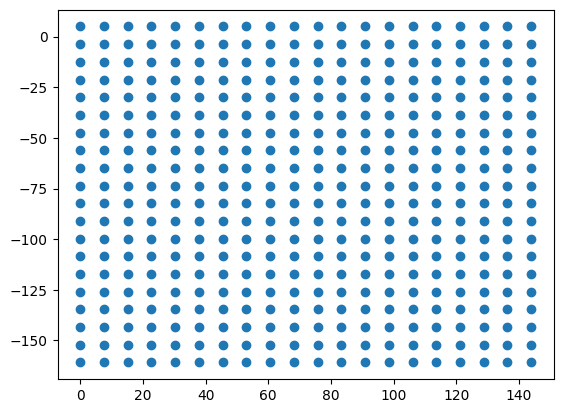

In [24]:
# Create a discrete grid to estimate on (reasonable resolution)
x = np.linspace(0, y_max,20)
y = np.linspace(-z_max,5,20)
locs = np.vstack((x,y))
locs = locs.T

xv, yv = np.meshgrid(x, y)
positions = np.vstack([xv.ravel(), yv.ravel()]).T

# just showing grid locations
plt.scatter(positions[:,0], positions[:,1])
plt.show()


In [25]:
# perform kriging for all three thesholds
results_k1 = kriging_grid(data_k1, positions, range_=variogram_parameters1[0], sill=variogram_parameters1[1])
results_k2 = kriging_grid(data_k2, positions, range_=variogram_parameters2[0], sill=variogram_parameters2[1])
results_k3 = kriging_grid(data_k3, positions, range_=variogram_parameters3[0], sill=variogram_parameters3[1])
results_k4 = kriging_grid(data_k4, positions, range_=variogram_parameters4[0], sill=variogram_parameters4[1])
results_k5 = kriging_grid(data_k5, positions, range_=variogram_parameters5[0], sill=variogram_parameters5[1])
results_k6 = kriging_grid(data_k6, positions, range_=variogram_parameters6[0], sill=variogram_parameters6[1])
results_k7 = kriging_grid(data_k7, positions, range_=variogram_parameters7[0], sill=variogram_parameters7[1])
results_k8 = kriging_grid(data_k8, positions, range_=variogram_parameters8[0], sill=variogram_parameters8[1])
results_k9 = kriging_grid(data_k9, positions, range_=variogram_parameters9[0], sill=variogram_parameters9[1])
results_k10 = kriging_grid(data_k10, positions, range_=variogram_parameters10[0], sill=variogram_parameters10[1])

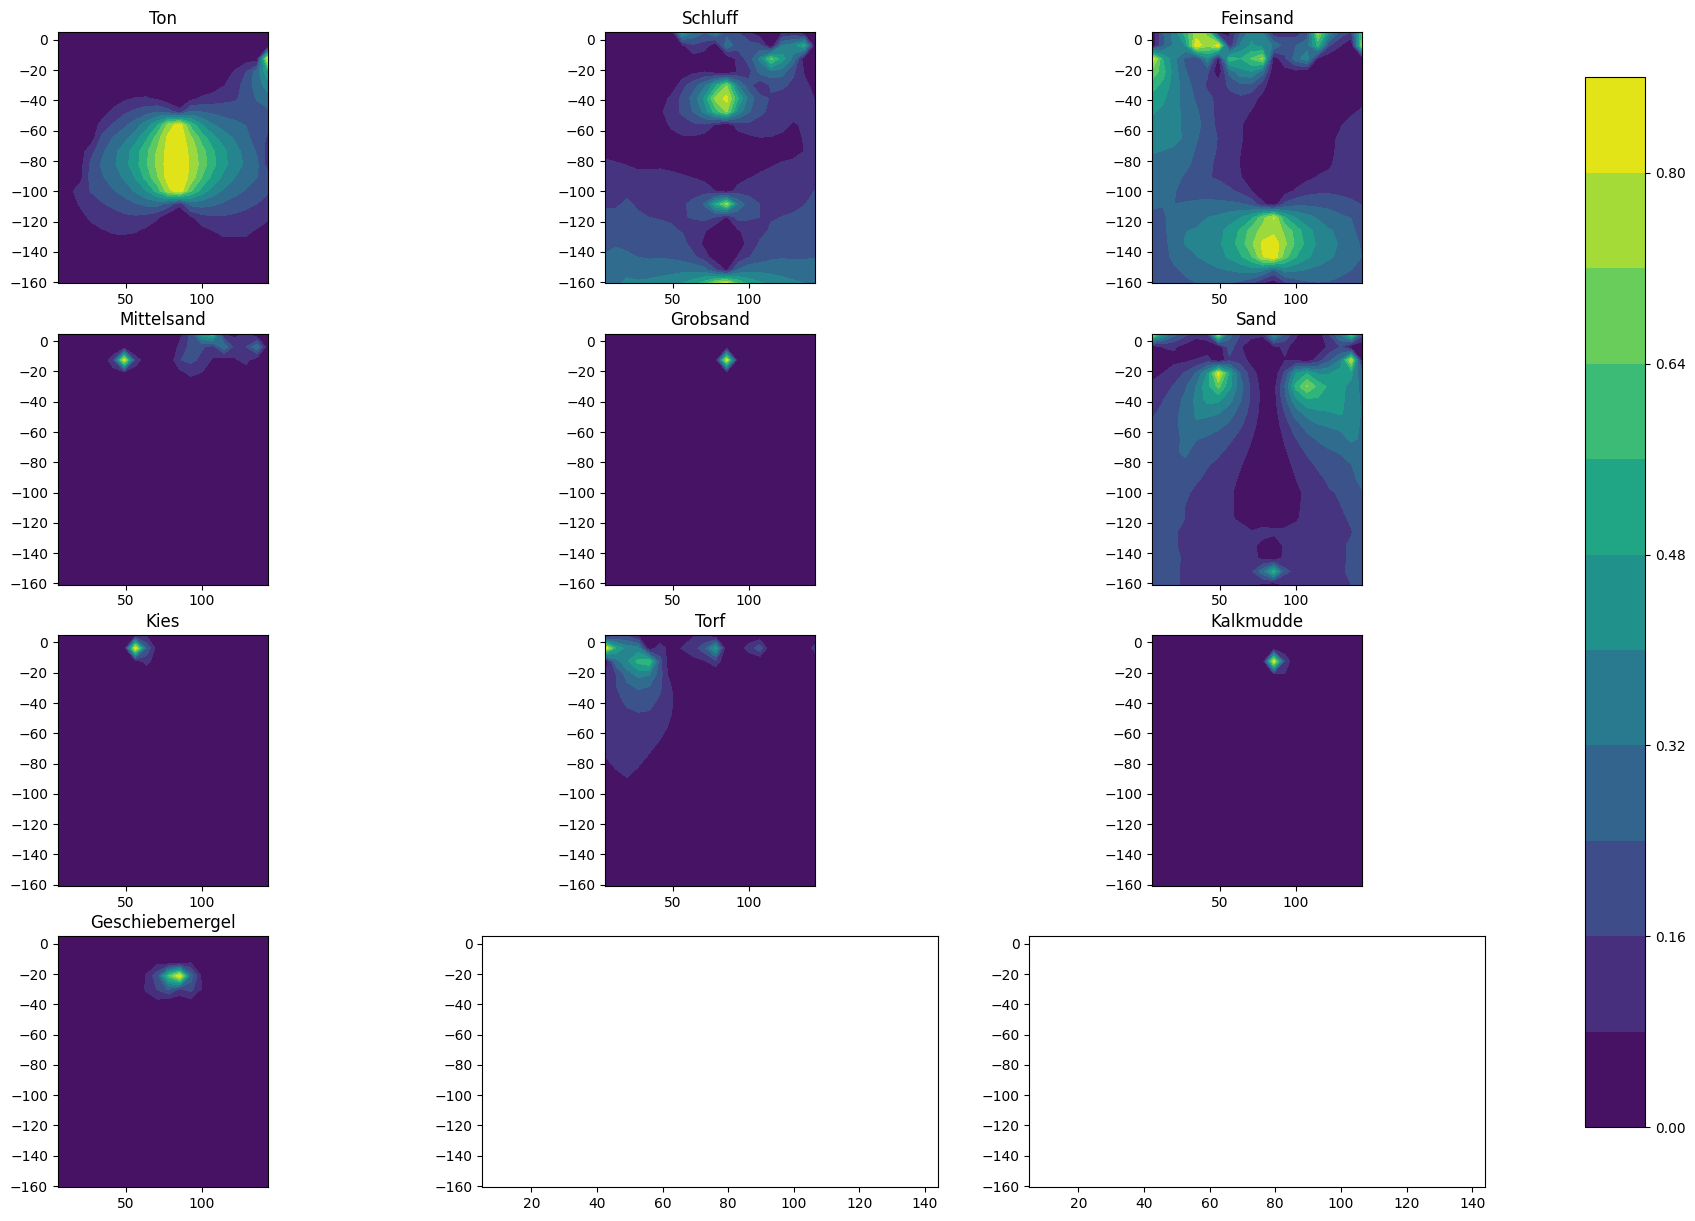

In [26]:
#without normalized weighted facies
# Create an empty DataFrame for the results
result_df = pd.DataFrame({'Y': np.linspace(-z_max, 5, 400),
                          'X': np.linspace(5, y_max, 400)})

# Add the weighted facies values based on the probability maps
result_df['Weighted_Value_Ton'] = results_k1
result_df['Weighted_Value_Schluff'] = results_k2
result_df['Weighted_Value_Feinsand'] = results_k3
result_df['Weighted_Value_Mittelsand'] = results_k4
result_df['Weighted_Value_Grobsand'] = results_k5
result_df['Weighted_Value_Sand'] = results_k6
result_df['Weighted_Value_Kies'] = results_k7
result_df['Weighted_Value_Torf'] = results_k8
result_df['Weighted_Value_Kalkmudde'] = results_k9
result_df['Weighted_Value_Geschiebemergel'] = results_k10

## Normalize probabilities to ensure they add up to one
results_comb = np.vstack((results_k1, results_k2, results_k3, results_k4, results_k5, results_k6, results_k7, results_k8, results_k9, results_k10)).T
#normalized_results_comb = results_comb / np.sum(results_comb, axis=1, keepdims=True)
#
## Check if the sum of normalized probabilities for each cell is equal to one
#print("Min sum:", np.min(np.sum(normalized_results_comb, axis=1)))
#print("Max sum:", np.max(np.sum(normalized_results_comb, axis=1)))
#
## Calculate the weighted conductivity using normalized probabilities
#result_df['Weighted_Value_Ton'] = normalized_results_comb[:, 0]
#result_df['Weighted_Value_Schluff'] = normalized_results_comb[:, 1]
#result_df['Weighted_Value_Feinsand'] = normalized_results_comb[:, 2]
#result_df['Weighted_Value_Mittelsand'] = normalized_results_comb[:, 3]
#result_df['Weighted_Value_Grobsand'] = normalized_results_comb[:, 4]
#result_df['Weighted_Value_Sand'] = normalized_results_comb[:, 5]
#result_df['Weighted_Value_Kies'] = normalized_results_comb[:, 6]
#result_df['Weighted_Value_Torf'] = normalized_results_comb[:, 7]
#result_df['Weighted_Value_Kalkmudde'] = normalized_results_comb[:, 8]
#result_df['Weighted_Value_Geschiebemergel'] = normalized_results_comb[:, 9]
#result_df['Weighted_Conductivity'] = (result_df['Weighted_Value_Ton'] * 1.52) + (result_df['Weighted_Value_Schluff'] * 1.83) + (result_df['Weighted_Value_Feinsand'] * 2.71) + (result_df['Weighted_Value_Mittelsand'] * 3.02) + (result_df['Weighted_Value_Grobsand'] * 2.04) + (result_df['Weighted_Value_Sand'] * 2.78) + (result_df['Weighted_Value_Kies'] * 2) + (result_df['Weighted_Value_Torf'] * 1.69) + (result_df['Weighted_Value_Kalkmudde'] * 0.69) + (result_df['Weighted_Value_Geschiebemergel'] * 2.87) 
#
## Output the resulting DataFrame
#print(result_df)

# Create subplots for plotting
fig, ax = plt.subplots(4, 3, figsize=(20, 15))

# Set plot limits
for i in range(4):
    for j in range(3):
        ax[i, j].set_ylim(-z_max, 5)
        ax[i, j].set_xlim(5, y_max)

# Creating the contourf kriging result for each facies
x = np.linspace(5, y_max, 20)
y = np.linspace(-z_max, 5, 20)
X, Y = np.meshgrid(x, y)

# Reshape results for contour plot
facies_names = ['Ton', 'Schluff', 'Feinsand', 'Mittelsand', 'Grobsand', 'Sand', 'Kies', 'Torf', 'Kalkmudde', 'Geschiebemergel']
for i in range(10):
    Z = results_comb[:, i].reshape(X.shape)
    CS = ax[i // 3, i % 3].contourf(X, Y, Z, 10, cmap=plt.cm.viridis)
    ax[i // 3, i % 3].set_aspect('equal', adjustable='box')
    ax[i // 3, i % 3].title.set_text(f'{facies_names[i]}')

# Add colorbar
cb_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar = fig.colorbar(CS, cax=cb_ax)

# Show the plot
plt.show()

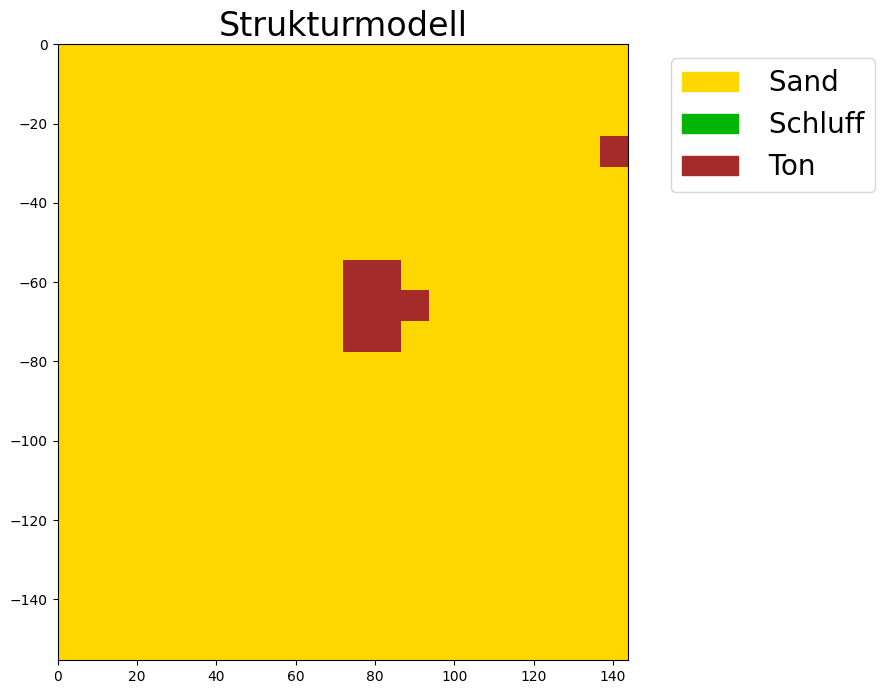

In [13]:
#structure modell 
# Combine results for all ten facies
results_comb = np.vstack((results_k1, results_k2, results_k3, results_k4, results_k5, results_k6, results_k7, results_k8, results_k9, results_k10)).T

# Finding facies with the highest probability for each location
highest_prob = np.argmax(results_comb, axis=1)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

Z10 = highest_prob.reshape(X.shape)

CS10 = ax.imshow(Z10, origin='lower', cmap=plt.cm.plasma, extent=[0, y_max, -z_max, 0])

ax.set_aspect('equal', adjustable='box')
# Change the font size of the title
ax.title.set_text('Strukturmodell')
ax.title.set_fontsize(24)  # You can set the desired font size here


values = np.unique(Z10.ravel())

# Facies names according to the previous Facies definitions
facies_names = ['Ton', 'Schluff', 'Feinsand', 'Mittelsand', 'Grobsand', 'Sand', 'Kies', 'Torf', 'Kalkmudde', 'Geschiebemergel']

# Some matplotlib labeling magic
# get the colors of the values, according to the colormap used by imshow
colors = [CS10.cmap(CS10.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=colors[i], label=f"{facies_names[i]}") for i in range(len(values))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, prop={'size': 20})

plt.show()

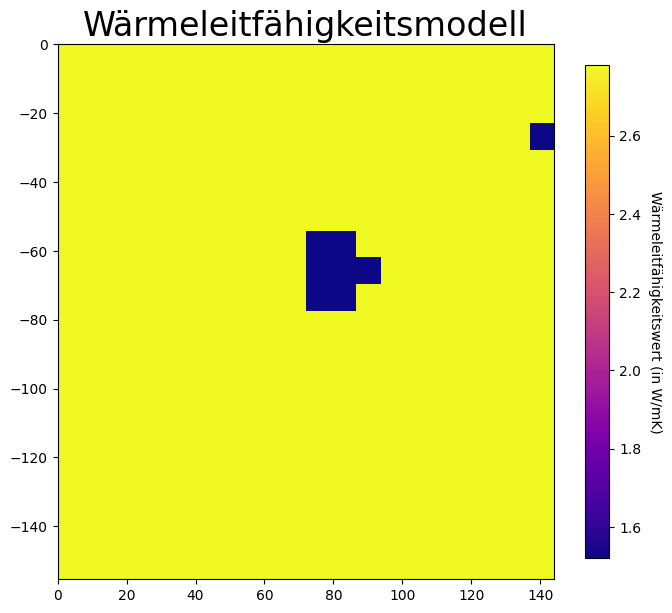

In [14]:
# Thermal conductivity map based on structure model
# Probability maps for each facies
results_comb = np.vstack((results_k1, results_k2, results_k3, results_k4, results_k5, results_k6, results_k7, results_k8, results_k9, results_k10)).T

# Finding facies with the highest probability for each location
highest_prob = np.argmax(results_comb, axis=1)

# Thermal conductivity values for each facies
thermal_conductivity_values = [1.52, 1.86, 2.71, 3.02, 2.04, 2.78, 2, 1.69, 0.69, 2.87]

# Thermal conductivity values for each location based on the highest probability facies
thermal_conductivity_map = np.array([thermal_conductivity_values[z] for z in highest_prob])

# Reshape for display
thermal_conductivity_map = thermal_conductivity_map.reshape(X.shape)

# Plotting the thermal conductivity model
fig, ax = plt.subplots(figsize=(8, 8))

CS = ax.imshow(thermal_conductivity_map, origin='lower', cmap=plt.cm.plasma, extent=[0, y_max, -z_max, 0])

ax.set_aspect('equal', adjustable='box')
ax.title.set_text('Wärmeleitfähigkeitsmodell')

# Farbleiste für Wärmeleitfähigkeitswerte erstellen und die Größe anpassen
cbar = plt.colorbar(CS, ax=ax, orientation='vertical', shrink=0.8)
cbar.set_label('Wärmeleitfähigkeitswert (in W/mK)', rotation=270, labelpad=15)

plt.show()

In [ ]:
#termal conductivity modell directly based on propapility map
# Create an empty DataFrame for the results
result_df = pd.DataFrame({'Y': np.linspace(-z_max, 5, 400),
                          'X': np.linspace(5, y_max, 400)})

# Add the weighted facies values based on the probability maps
result_df['Weighted_Value_Ton'] = results_k1
result_df['Weighted_Value_Schluff'] = results_k2
result_df['Weighted_Value_Feinsand'] = results_k3
result_df['Weighted_Value_Mittelsand'] = results_k4
result_df['Weighted_Value_Grobsand'] = results_k5
result_df['Weighted_Value_Sand'] = results_k6
result_df['Weighted_Value_Kies'] = results_k7
result_df['Weighted_Value_Torf'] = results_k8
result_df['Weighted_Value_Kalkmudde'] = results_k9
result_df['Weighted_Value_Geschiebemergel'] = results_k10

# Normalize probabilities to ensure they add up to one
results_comb = np.vstack((results_k1, results_k2, results_k3, results_k4, results_k5, results_k6, results_k7, results_k8, results_k9, results_k10)).T
normalized_results_comb = results_comb / np.sum(results_comb, axis=1, keepdims=True)

# Check if the sum of normalized probabilities for each cell is equal to one
print("Min sum:", np.min(np.sum(normalized_results_comb, axis=1)))
print("Max sum:", np.max(np.sum(normalized_results_comb, axis=1)))

# Calculate the weighted conductivity using normalized probabilities
result_df['Weighted_Value_Ton'] = normalized_results_comb[:, 0]
result_df['Weighted_Value_Schluff'] = normalized_results_comb[:, 1]
result_df['Weighted_Value_Feinsand'] = normalized_results_comb[:, 2]
result_df['Weighted_Value_Mittelsand'] = normalized_results_comb[:, 3]
result_df['Weighted_Value_Grobsand'] = normalized_results_comb[:, 4]
result_df['Weighted_Value_Sand'] = normalized_results_comb[:, 5]
result_df['Weighted_Value_Kies'] = normalized_results_comb[:, 6]
result_df['Weighted_Value_Torf'] = normalized_results_comb[:, 7]
result_df['Weighted_Value_Kalkmudde'] = normalized_results_comb[:, 8]
result_df['Weighted_Value_Geschiebemergel'] = normalized_results_comb[:, 9]
result_df['Weighted_Conductivity'] = (result_df['Weighted_Value_Ton'] * 1.52) + (result_df['Weighted_Value_Schluff'] * 1.83) + (result_df['Weighted_Value_Feinsand'] * 2.71) + (result_df['Weighted_Value_Mittelsand'] * 3.02) + (result_df['Weighted_Value_Grobsand'] * 2.04) + (result_df['Weighted_Value_Sand'] * 2.78) + (result_df['Weighted_Value_Kies'] * 2) + (result_df['Weighted_Value_Torf'] * 1.69) + (result_df['Weighted_Value_Kalkmudde'] * 0.69) + (result_df['Weighted_Value_Geschiebemergel'] * 2.87) 

# Output the resulting DataFrame
print(result_df)

# Create subplots for plotting
fig, ax = plt.subplots(1, figsize=(8, 6))

# Set plot limits
ax.set_ylim(-z_max, 5)
ax.set_xlim(5, y_max)

# Check if the normalized probabilities now add up to one
print("Min sum after normalization:", np.min(np.sum(normalized_results_comb, axis=1)))
print("Max sum after normalization:", np.max(np.sum(normalized_results_comb, axis=1)))

# Creating the contourf kriging result
x = np.linspace(0, y_max, 20)
y = np.linspace(-z_max, 5, 20)
X, Y = np.meshgrid(x, y)
Z = result_df['Weighted_Conductivity'].values.reshape(X.shape)  # Use 'values' here

# Plot contourf kriging result
CS = ax.contourf(X, Y, Z, 10, cmap=plt.cm.plasma)

# Draw a random selection based on the normalized probabilities
# random_choice = np.random.choice(11, 1, p=normalized_results_comb[0])
# print("Random choice:", random_choice)

# ax.scatter(data[:,0], data[:,1], color='black')
# Set plot aspect and title
ax.set_aspect('equal', adjustable='box')
ax.title.set_text('Wärmeleitfähigkeitsmodell')

# Legende für Wärmeleitfähigkeitswerte erstellen und die Größe anpassen
cbar = plt.colorbar(CS, ax=ax, orientation='vertical', shrink=0.8)  # Sie können den shrink-Wert anpassen
cbar.set_label('Wärmeleitfähigkeitswert (in W/mK)', rotation=270, labelpad=15)

# Show the plot
plt.show()